In [1]:
import numpy as np
import pandas as pd
import argparse
import sys
import pickle
import pystan
import time
import os
import logging
from hashlib import md5
import matplotlib.pyplot as plt
from scipy.stats import laplace
from sklearn import linear_model

In [3]:
df = pd.read_csv("./../dat/evidence_elite_c.txt", sep="\t")

In [4]:
dff = df[-(df["exclude"])]
dff = dff.reset_index(drop=True)
dff

,sequence,raw_file,retention_time,pep,exclude,exp_id,peptide_id
0,_AAAAAAALQAK_,1608329A_NC_set#29B_180min_200NL_60C+N=3_250ms,96.072,1.248000e-03,False,2,3
1,_AAAAAAALQAK_,160818A_NC_set#26C_180min_200NL_60C,104.090,2.812700e-10,False,3,3
2,_AAAAAAALQAK_,160818A_NC_set#26C_180min_200NL_60C,104.100,2.779600e-04,False,3,3
3,_AAAAAAALQAK_,160629AEL160624PMRSAM00092_18B1,77.767,4.637300e-10,False,8,3
4,_AAAAAAALQAK_,160629AEL160624PMRSAM00092_18A2,73.488,4.637300e-10,False,9,3
5,_AAAAAAALQAK_,160629AEL160624PMRSAM00092_18A1,72.872,1.391700e-08,False,10,3
6,_AAAAAAALQAK_,160623AEL160624PMRSAM00092,60.512,6.971200e-12,False,11,3
7,_AAAAAAALQAK_,160623AEL160624PMRSAM00092_NC126,61.643,1.391700e-08,False,12,3
8,_AAAAAAALQAK_,160623AEL160624PMRSAM00092_NC126,61.643,8.870900e-02,False,12,3
9,_AAAAAAALQAK_,161018A_NC_set#38D_untergeted2,103.760,3.220800e-09,False,13,3


In [22]:
print(len(df["sequence"].unique()))
print(df["peptide_id"].max())
print(len(df["exp_id"].unique()))

502762
502761
112


In [10]:
# refactorize peptide id into stan_peptide_id, 
# to preserve continuity when feeding data into STAN
dff["stan_peptide_id"] = dff["sequence"].map({ind: val for val, ind in enumerate(dff["sequence"].unique())})
exp_names = dff["raw_file"].unique()
num_experiments = len(exp_names)
num_observations = dff.shape[0]
num_peptides = dff["stan_peptide_id"].max() + 1
retention_times = dff["retention_time"]
peptide_id = dff["peptide_id"]
stan_peptide_id = dff["stan_peptide_id"]
exp_id = dff["exp_id"]
pep_exp_all = dff["stan_peptide_id"].map(str) + " - " + dff["exp_id"].map(str)
pep_exp_pairs = pep_exp_all.unique()
num_pep_exp_pairs = len(pep_exp_pairs)

muij_map = pep_exp_all.map({ind: val for val, ind in enumerate(pep_exp_pairs)})
splt = pd.Series(pep_exp_pairs).str.split(" - ")
muij_to_pep = splt.str.get(0).map(int)
muij_to_exp = splt.str.get(1).map(int)
print(str(num_pep_exp_pairs) + " peptide-experiment pairs.")

pep = dff["pep"]
pep = pep + np.finfo(float).eps

242761 peptide-experiment pairs.


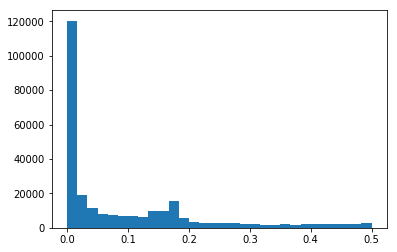

In [51]:
plt.hist(pep, bins=30)
plt.show()

In [12]:
stan_data = {
    "num_experiments": num_experiments,
    "num_peptides": num_peptides,
    "num_pep_exp_pairs": num_pep_exp_pairs,
    "num_total_observations": num_observations,
    "muij_map": muij_map+1,
    "muij_to_pep": (muij_to_pep+1).tolist(),
    "muij_to_exp": (muij_to_exp+1).tolist(),
    "experiment_id": (exp_id+1).tolist(),
    "peptide_id": (stan_peptide_id+1).tolist(),
    "retention_times": retention_times.tolist(),
    "mean_log_rt": np.mean(np.log(retention_times)),
    "sd_log_rt": np.std(np.log(retention_times)),
    "pep": pep.tolist(),
    "max_retention_time": retention_times.max()
}

In [118]:
filter_pep = 0.5
rt_distortion = 5.0
mu_min = 1.0

def get_mu(x):
    weights = ((1 - x["pep"].values) - (1 - filter_pep)) / filter_pep
    return np.sum(x["retention_time"].values * weights) / np.sum(weights)

mu_init = dff.groupby("stan_peptide_id")[["pep", "retention_time"]].apply(get_mu).values + np.random.normal(0, rt_distortion, num_peptides)

# negative or very low retention times not allowed. floor at 5 minutes
mu_init[mu_init <= mu_min] = mu_min
# canonical retention time shouldn't be bigger than largest real RT
mu_max = retention_times.max()
mu_init[mu_init > mu_max] = mu_max

#np.savetxt("muinit.txt", mu_init)

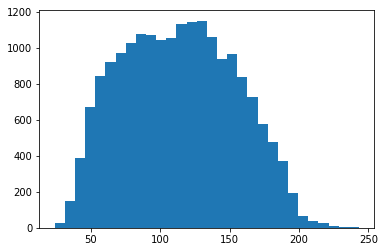

In [96]:
plt.hist(mu_init, bins=30)
plt.show()

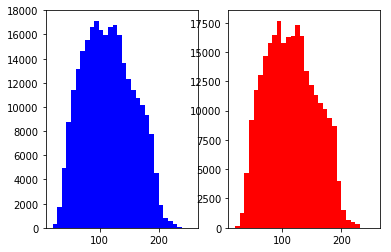

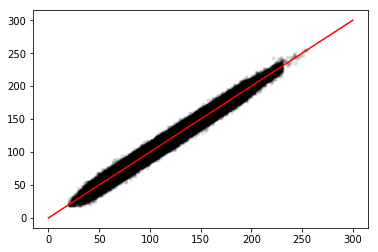

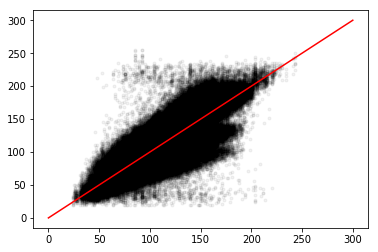

In [97]:
# take retention times and distort by +- 10 mins
rt_distorted = retention_times + np.random.normal(0, rt_distortion, len(retention_times))
# make sure distorted retention times stay within bounds of real ones
rt_distorted[rt_distorted > retention_times.max()] = retention_times.max()
rt_distorted[rt_distorted < retention_times.min()] = retention_times.min()

plt.subplot(121)
plt.hist(rt_distorted, bins=30, color='b')
plt.subplot(122)
plt.hist(retention_times, bins=30, color='r')
plt.show()

plt.plot(retention_times, rt_distorted, '.k', alpha=0.1)
plt.plot([0, 300], [0, 300], color='red')
plt.show()

plt.plot(mu_init[stan_peptide_id], rt_distorted, '.k', alpha=0.05)
plt.plot([0, 300], [0, 300], color='red')
plt.show()

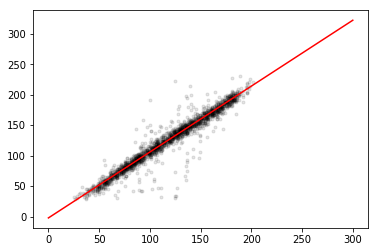

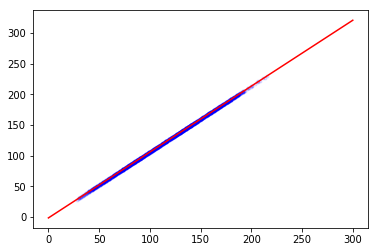

In [122]:
e = 1
mus = mu_init[stan_peptide_id[exp_id==e]]
rts = rt_distorted[exp_id==e]
peps = pep[exp_id==e]

plt.plot(mus, rts, '.k', alpha=0.1)
plt.plot([0, 300], [beta_init[0][0], beta_init[0][0] + (beta_init[1][0] * 300)], '-r')
plt.show()

reg.fit(mus.reshape(-1, 1), rts, 1-peps)
beta0 = reg.intercept_
beta1 = reg.coef_[0]

mu_pred = (rts - beta0) / beta1

plt.plot(mu_pred, rts, '.b', alpha=0.1)
plt.plot([0, 300], [beta0, beta0+(beta1 * 300)], '-r')
plt.show()

In [119]:
# initialize priors for the segmented linear regression
# first element of vector is beta_0, or the intercept
# second element is beta_1 and beta_2, the slopes of the two segments
beta_init = np.array((np.repeat(10, num_experiments), np.repeat(1, num_experiments)), dtype=float)

mu_pred = np.zeros(num_peptides)
# temporary data frame to quickly map over in the loop
dft = pd.DataFrame(dict(stan_peptide_id=stan_peptide_id, exp_id=exp_id, pep=pep, retention_time=rt_distorted))

reg = linear_model.LinearRegression()
prior_iters=15

for i in range(0, prior_iters):
    # for each experiment, fit a simple linear regression
    # between the distorted RTs and the initial canonical retention times
    for j, e in enumerate(np.sort(exp_id.unique())):
        #print(e)
        idx = (exp_id == e)
        rt_cur = rt_distorted[idx]
        mu_cur = mu_init[stan_peptide_id[idx]]
        pep_cur = pep[idx]

        #m, c = np.polyfit(mu_cur, rt_cur, 1, w=(1 - pep_cur))
        #beta_init[(0,1), j] = [c, m]
        
        reg.fit(mu_cur.reshape(-1, 1), rt_cur, 1 - pep_cur)
        beta_init[0, j] = reg.intercept_
        beta_init[1, j] = reg.coef_[0]

    # calculate new set of canonical RTs based on linear regression params
    mu_pred = (rt_distorted - beta_init[0][exp_id]) / beta_init[1][exp_id] 
    # make sure new canonical RTs are within same range as distorted RTs
    mu_pred[mu_pred <= 0] = rt_distorted.min()
    mu_pred[mu_pred >= rt_distorted.max()] = rt_distorted.max()
    
    dft["retention_time"] = np.copy(mu_pred)

    mu_prev = mu_init

    # new set of priors for canonical RTs based on weighted combination of
    # this set of predicted canonical RTs
    mu_init = dft.groupby("stan_peptide_id")[["pep", "retention_time"]].apply(get_mu).values

    print("Iter " + str(i + 1) + " | Avg. canonical RT shift: " + "{:.5f}".format(pow(np.sum(mu_prev - mu_init), 2) / len(mu_init)))

0    103.236179
1    103.650800
2    101.238870
3     88.093473
4     84.898725
Name: retention_time, dtype: float64
Iter 1 | Avg. canonical RT shift: 870.83319
0    102.773564
1    102.806549
2    100.420892
3     92.462293
4     92.494392
Name: retention_time, dtype: float64
Iter 2 | Avg. canonical RT shift: 207.33984
0    102.367295
1    102.493351
2    100.117923
3     93.607870
4     94.586150
Name: retention_time, dtype: float64
Iter 3 | Avg. canonical RT shift: 1.65434
0    102.197995
1    102.388138
2    100.015429
3     93.872942
4     95.081170
Name: retention_time, dtype: float64
Iter 4 | Avg. canonical RT shift: 1.78588
0    102.127908
1    102.344879
2     99.972126
3     93.919631
4     95.183150
Name: retention_time, dtype: float64
Iter 5 | Avg. canonical RT shift: 2.81230
0    102.092329
1    102.319430
2     99.945649
3     93.913287
4     95.190904
Name: retention_time, dtype: float64
Iter 6 | Avg. canonical RT shift: 2.53671
0    102.068117
1    102.299036
2     99.9